## Model inference

In [1]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", module="IPython")

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
# project_root = "."
if project_root not in sys.path:
    sys.path.append(project_root)
# Set the environment variables from the file <root_dir>/.env
from backend.models import config
settings = config.HopsworksSettings(_env_file=f"{project_root}/.env")

HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from backend import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 13, 9, 58, 602782)

### Initialize project and retrieve model

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

2025-11-18 13:09:58,829 INFO: Initializing external client
2025-11-18 13:09:58,830 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 13:09:59,458 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 13:10:00,339 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279162


In [5]:
country = locals().get("country", 'sweden')
city = locals().get("city", 'stockholm')
street = locals().get("street", 'sundbyberg-tulegatan-9')
lag_feature = locals().get("lag_feature", "pm25_lag_1")

In [6]:
street_new = street.replace('-', '_')
street_new = street_new.replace('ä', 'ae')
street_new = street_new.replace('ö', 'oe')
street_new = street_new.replace('å', 'oa')

In [7]:
print(street)

sundbyberg-tulegatan-9


In [8]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_general",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 13:10:08,831 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/602050 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/122856 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/122917 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/22403 elapsed<00:00 remaining<?

In [9]:
retrieved_model.training_metrics

{'r squared': 0.7376168460593497, 'MSE': 28.052595}

In [10]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model_all_sensors.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.0040631E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
air_quality_fg = fs.get_feature_group(
    name='air_quality_with_all_lags',
    version=1,
)

In [12]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [13]:
aq_hist: pd.DataFrame = air_quality_fg.read()
aq_hist["date"] = pd.to_datetime(aq_hist["date"]).dt.tz_localize(None)

aq_loc = aq_hist[
    (aq_hist["country"] == country) &
    (aq_hist["city"] == city) &
    (aq_hist["street"] == street)
].sort_values("date")

aq_loc.tail(5).head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.49s) 


,date,pm25,country,city,street,url,pm25_rolling_3d,pm25_rolling_2d,pm25_lag_1,pm25_lag_2,pm25_lag_3
15263,2025-11-13,12.0,sweden,stockholm,sundbyberg-tulegatan-9,https://api.waqi.info/feed/@13988,21.666666,24.5,24.0,25.0,16.0
25271,2025-11-14,14.0,sweden,stockholm,sundbyberg-tulegatan-9,https://api.waqi.info/feed/@13988,20.333334,18.0,12.0,24.0,25.0
25284,2025-11-15,9.0,sweden,stockholm,sundbyberg-tulegatan-9,https://api.waqi.info/feed/@13988,16.666666,13.0,14.0,12.0,24.0
25294,2025-11-17,12.0,sweden,stockholm,sundbyberg-tulegatan-9,https://api.waqi.info/feed/@13988,11.666667,11.5,9.0,14.0,12.0
25306,2025-11-18,23.0,sweden,stockholm,sundbyberg-tulegatan-9,https://api.waqi.info/feed/@13988,11.666667,10.5,12.0,9.0,14.0


In [14]:
import yaml
with open(f"{project_root}/backend/sensors/sensors.yml", "r") as f:
    config = yaml.safe_load(f)

prediction_list = []

if lag_feature == 'pm25':
    # not implemented, do not call ts
    weather_all = weather_fg.filter(weather_fg.date >= today).read()
    weather_all["date"] = pd.to_datetime(weather_all["date"]).dt.tz_localize(None)
    batch_data = weather_all[
        (weather_all["city"] == city)
    ].copy()
    batch_data = batch_data.sort_values("date").reset_index(drop=True)
    batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]
    )
    prediction_list.append(batch_data)
else:
    aq_hist = air_quality_fg.read()
    weather_all = weather_fg.filter(weather_fg.date >= today).read()
    for sensor in config["sensors"]:
        batch_data = util.predict_pm25_with_single_feature(
            model=retrieved_xgboost_model,
            weather_fg=weather_all,
            air_quality_fg=aq_hist,
            country=sensor['country'],
            city=sensor['city'],
            street=sensor['street'],
            today=today,
            feature_name=lag_feature
        )
        prediction_list +=batch_data

    batch_data = pd.DataFrame(prediction_list)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.25s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.56s) 


In [15]:
print(prediction_list)

[{'date': Timestamp('2025-11-19 00:00:00'), 'temperature_2m_mean': -1.3, 'precipitation_sum': 0.0, 'wind_speed_10m_max': 4.73506, 'wind_direction_10m_dominant': 351.2539, 'country': 'sweden', 'city': 'stockholm', 'street': 'stockholm-st-eriksgatan-83', 'predicted_pm25': 31.465954, 'days_before_forecast_day': 0}, {'date': Timestamp('2025-11-20 00:00:00'), 'temperature_2m_mean': 1.15, 'precipitation_sum': 0.1, 'wind_speed_10m_max': 16.394829, 'wind_direction_10m_dominant': 8.841739, 'country': 'sweden', 'city': 'stockholm', 'street': 'stockholm-st-eriksgatan-83', 'predicted_pm25': 22.886364, 'days_before_forecast_day': 1}, {'date': Timestamp('2025-11-21 00:00:00'), 'temperature_2m_mean': -3.35, 'precipitation_sum': 0.1, 'wind_speed_10m_max': 15.575981, 'wind_direction_10m_dominant': 303.6901, 'country': 'sweden', 'city': 'stockholm', 'street': 'stockholm-st-eriksgatan-83', 'predicted_pm25': 21.018686, 'days_before_forecast_day': 2}, {'date': Timestamp('2025-11-22 00:00:00'), 'temperature

In [16]:
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,country,city,street,predicted_pm25,days_before_forecast_day
0,2025-11-19,-1.30,0.0,4.735060,351.253906,sweden,stockholm,stockholm-st-eriksgatan-83,31.465954,0
1,2025-11-20,1.15,0.1,16.394829,8.841739,sweden,stockholm,stockholm-st-eriksgatan-83,22.886364,1
2,2025-11-21,-3.35,0.1,15.575981,303.690094,sweden,stockholm,stockholm-st-eriksgatan-83,21.018686,2
3,2025-11-22,1.60,0.0,15.463246,245.224884,sweden,stockholm,stockholm-st-eriksgatan-83,24.726969,3
4,2025-11-23,3.45,0.1,10.144082,117.474350,sweden,stockholm,stockholm-st-eriksgatan-83,24.962128,4
...,...,...,...,...,...,...,...,...,...,...
61,2025-11-20,1.15,0.1,16.394829,8.841739,sweden,stockholm,hägersten,1.686448,1
62,2025-11-21,-3.35,0.1,15.575981,303.690094,sweden,stockholm,hägersten,1.968432,2
63,2025-11-22,1.60,0.0,15.463246,245.224884,sweden,stockholm,hägersten,3.010622,3
64,2025-11-23,3.45,0.1,10.144082,117.474350,sweden,stockholm,hägersten,4.653161,4


In [17]:
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,country,city,street,predicted_pm25,days_before_forecast_day
0,2025-11-19,-1.3,0.0,4.735060,351.253906,sweden,stockholm,stockholm-st-eriksgatan-83,31.465954,0
24,2025-11-19,-1.3,0.0,4.735060,351.253906,sweden,stockholm,sweden-hägersten-älvsjö-stadsdelsområde-nyboho...,0.436180,0
36,2025-11-19,-1.3,0.0,4.735060,351.253906,sweden,stockholm,liljeholmen,0.436180,0
18,2025-11-19,-1.3,0.0,4.735060,351.253906,sweden,stockholm,ljusslingan,0.938018,0
42,2025-11-19,-1.3,0.0,4.735060,351.253906,sweden,stockholm,sundbyberg-tulegatan-9,30.164967,0
...,...,...,...,...,...,...,...,...,...,...
59,2025-11-24,2.8,0.0,11.269782,63.435013,sweden,stockholm,nacka,1.412756,5
23,2025-11-24,2.8,0.0,11.269782,63.435013,sweden,stockholm,ljusslingan,0.178097,5
29,2025-11-24,2.8,0.0,11.269782,63.435013,sweden,stockholm,sweden-hägersten-älvsjö-stadsdelsområde-nyboho...,0.178097,5
11,2025-11-24,2.8,0.0,11.269782,63.435013,sweden,stockholm,stockholm-hornsgatan-108-gata,20.451908,5


In [18]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 0 to 65
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         66 non-null     datetime64[ns]
 1   temperature_2m_mean          66 non-null     float32       
 2   precipitation_sum            66 non-null     float32       
 3   wind_speed_10m_max           66 non-null     float32       
 4   wind_direction_10m_dominant  66 non-null     float32       
 5   country                      66 non-null     object        
 6   city                         66 non-null     object        
 7   street                       66 non-null     object        
 8   predicted_pm25               66 non-null     float32       
 9   days_before_forecast_day     66 non-null     int64         
dtypes: datetime64[ns](1), float32(5), int64(1), object(3)
memory usage: 4.4+ KB


### Create Forecast Graph

2025-11-18 13:10:54,020 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



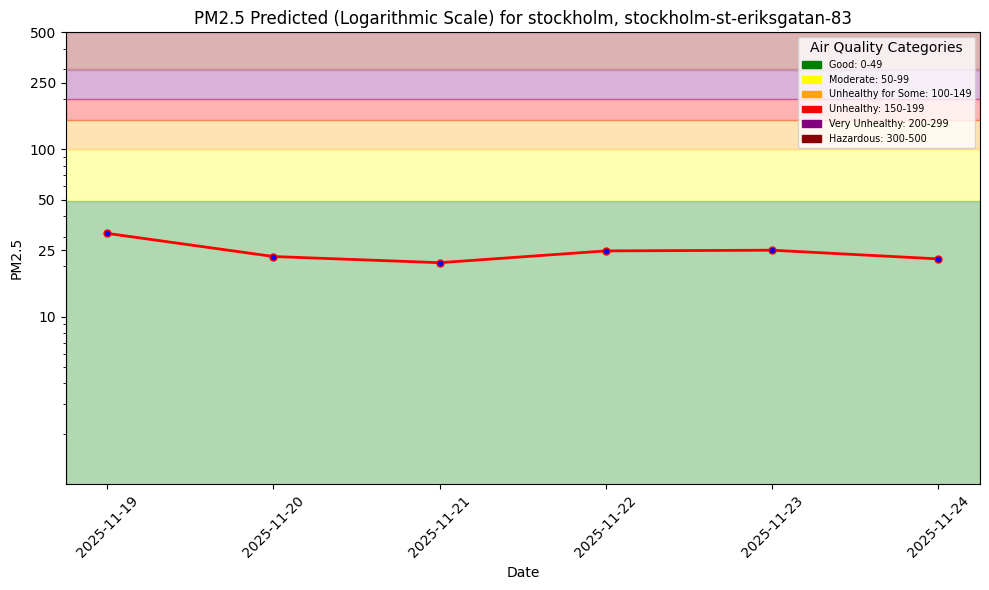

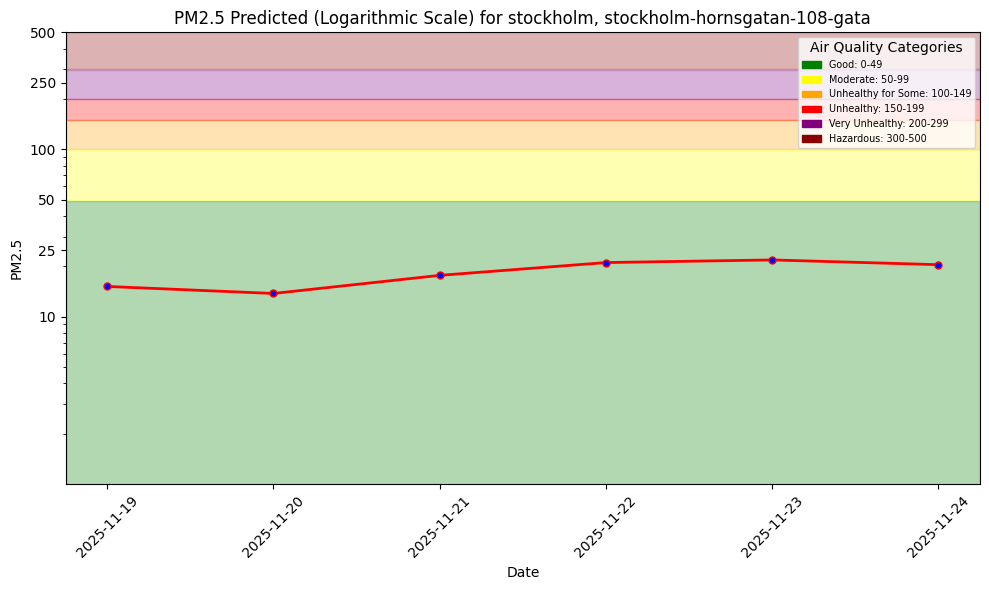

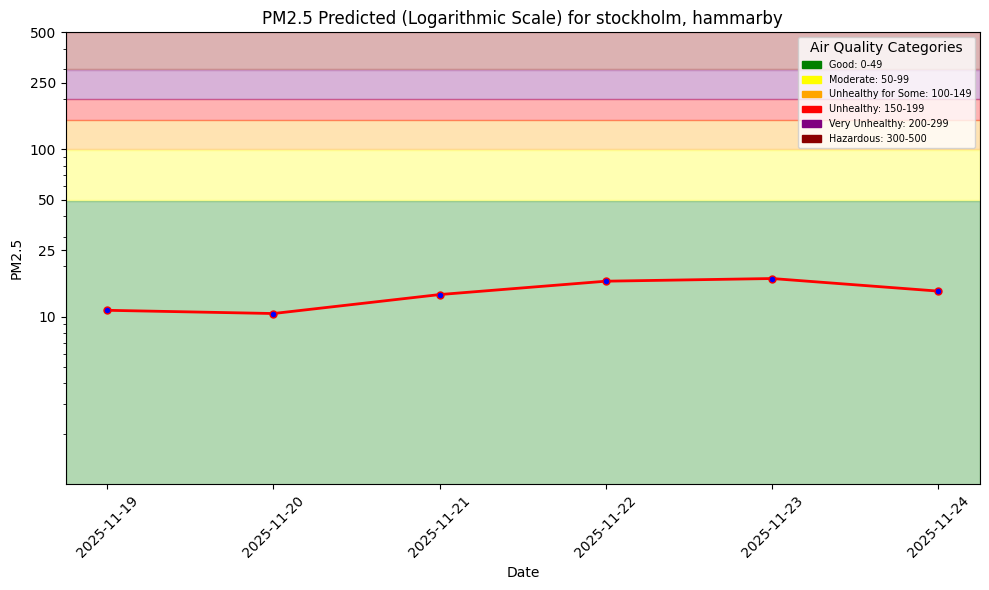

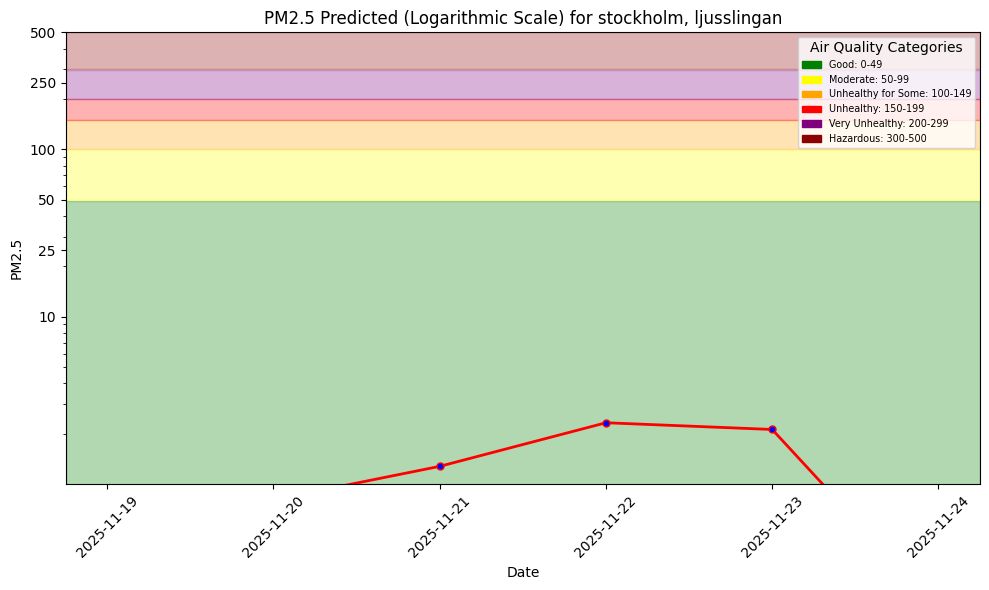

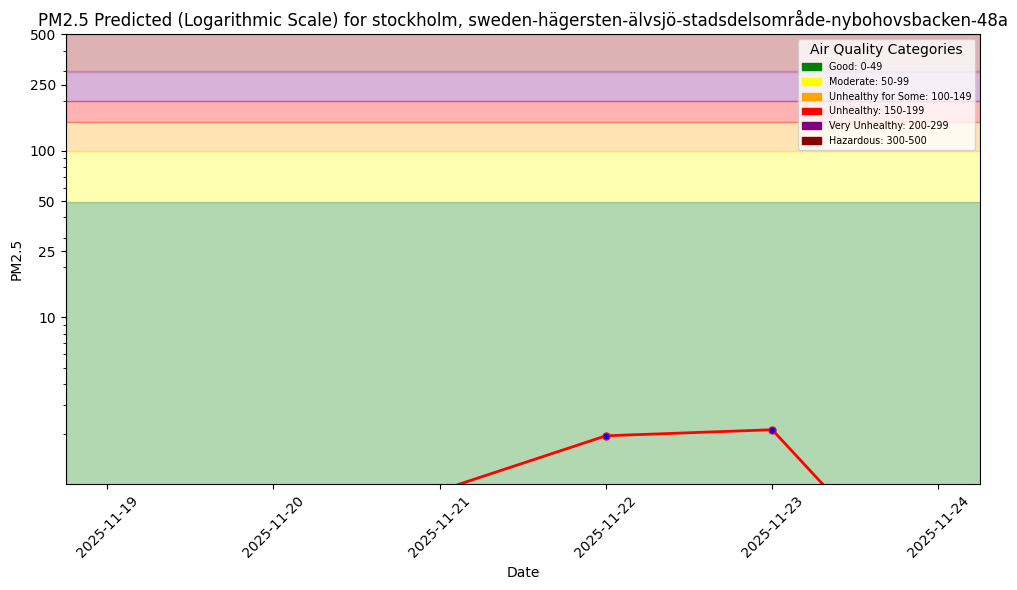

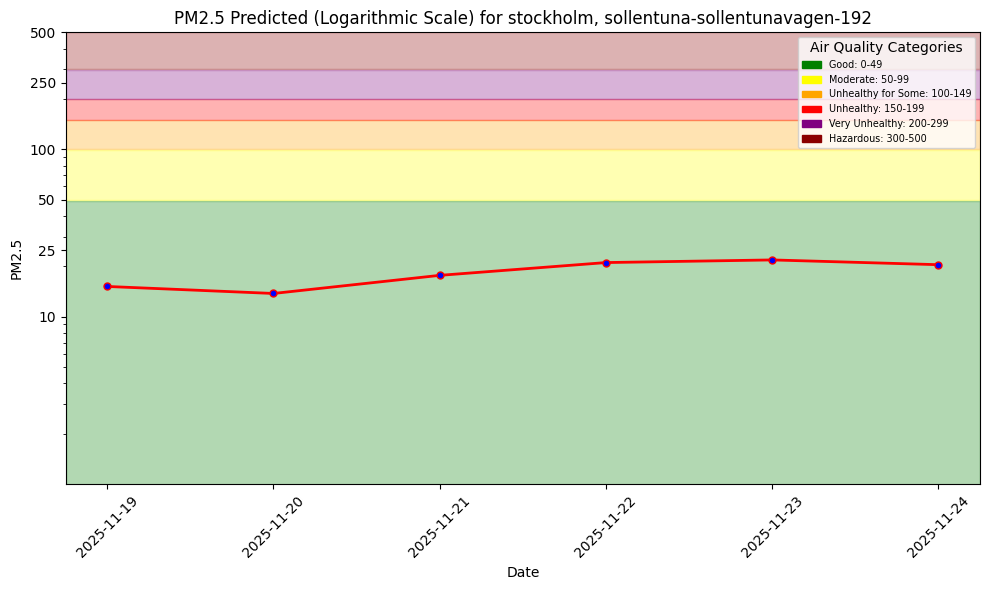

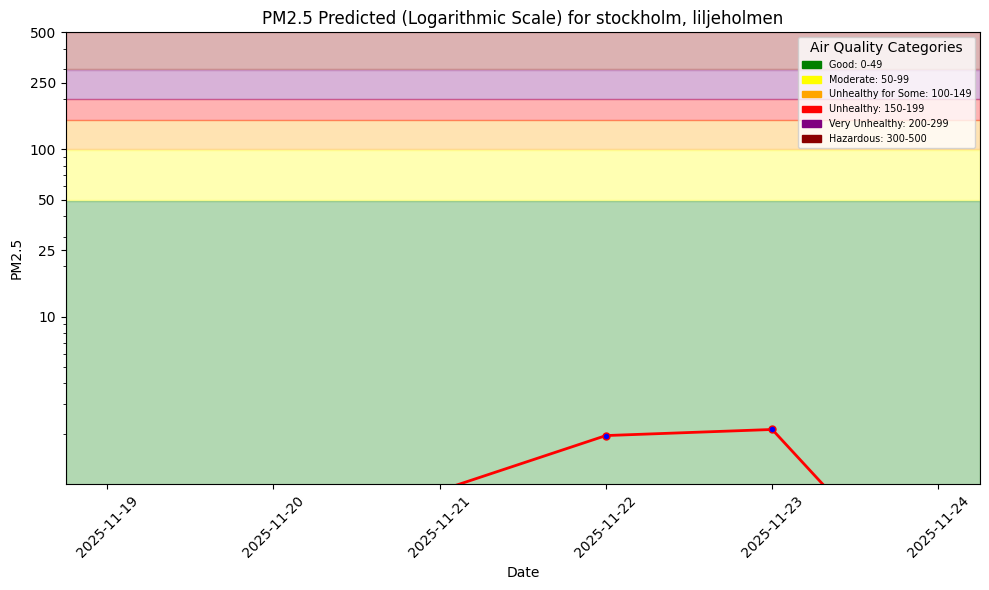

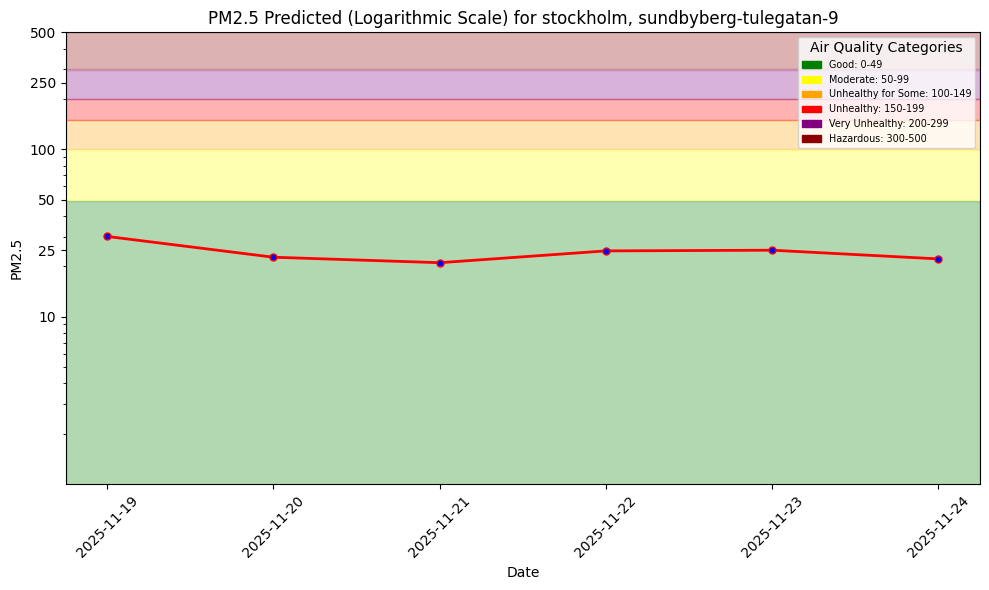

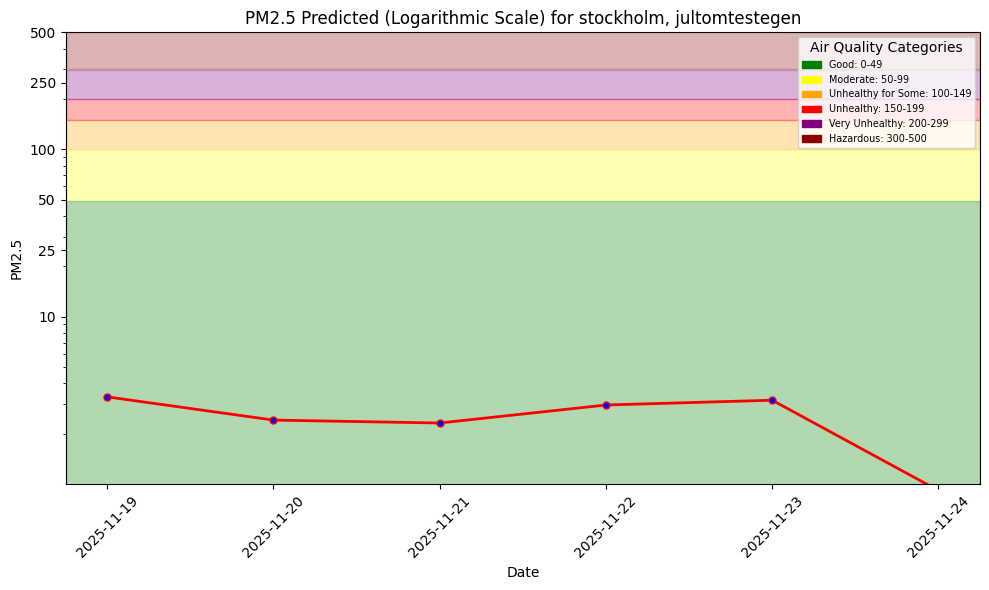

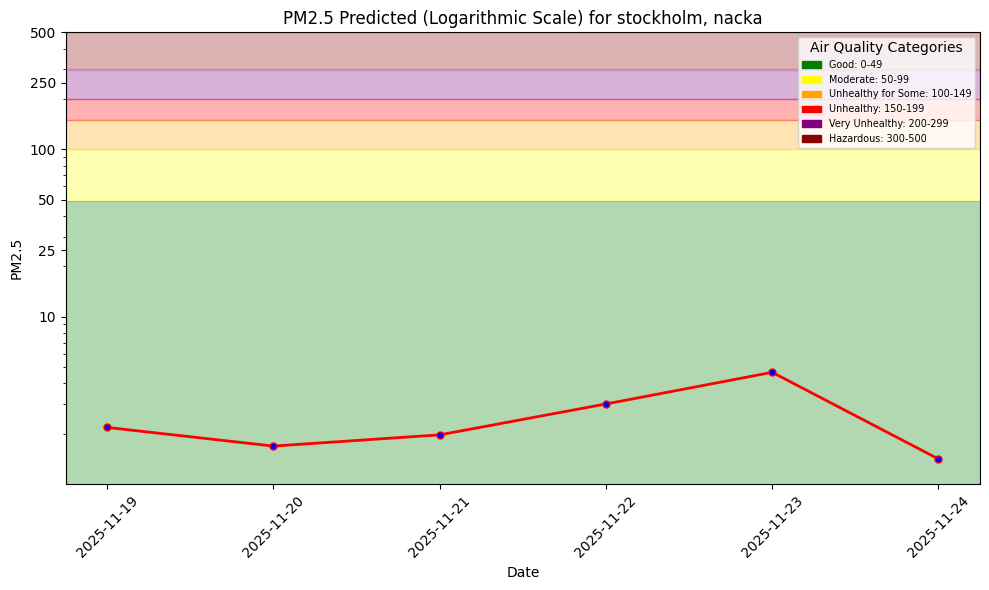

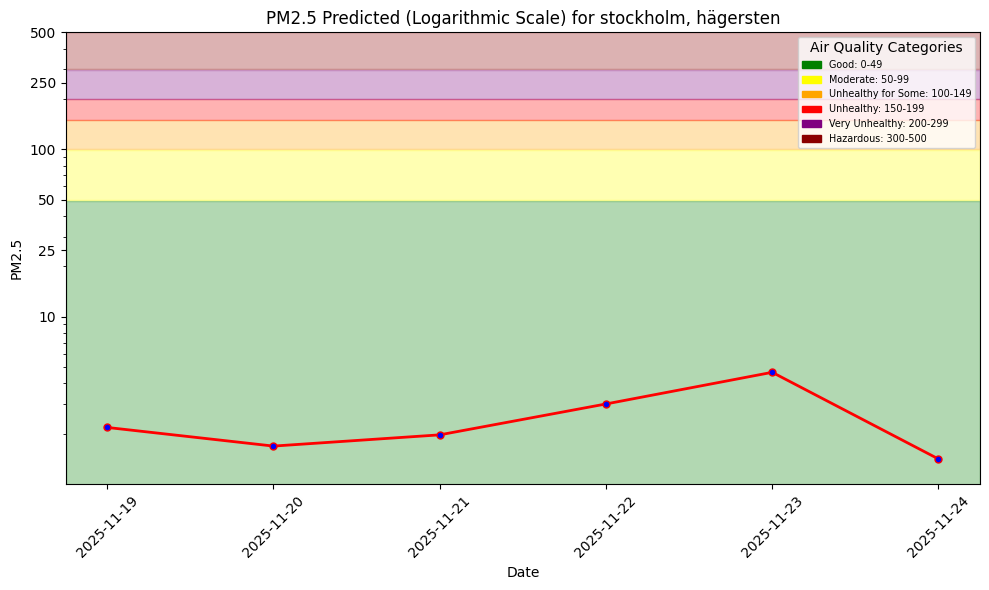

In [19]:
model_dir = f"{project_root}/backend/air_quality_models/general"
if not os.path.exists(model_dir):
    os.makedirs(model_dir, exist_ok=True)
pred_file_path = model_dir + "/predictions"
if not os.path.exists(pred_file_path):
    os.mkdir(pred_file_path)
for sensor in config["sensors"]:
    street_new = sensor['street'].replace('-', '_')
    street_new = street_new.replace('ä', 'ae')
    street_new = street_new.replace('ö', 'oe')
    street_new = street_new.replace('å', 'oa')
    plt = util.plot_air_quality_forecast(
        sensor['city'], 
        sensor['street'], 
        batch_data[batch_data['street'] == sensor['street']], 
        pred_file_path + f"/pm25_forecast_{street_new}_{today.strftime('%Y_%m_%d')}.png")
    plt.show()

### Create hindcast graph

In [20]:
monitor_fg = fs.get_or_create_feature_group(
    name=f'aq_predictions_general',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [29]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279162/fs/1265774/fg/1721916


Uploading Dataframe: 100.00% |██████████| Rows 66/66 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_general_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279162/jobs/named/aq_predictions_general_1_offline_fg_materialization/executions
2025-11-17 23:56:10,874 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 23:56:14,075 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 23:57:40,098 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 23:57:40,273 INFO: Waiting for log aggregation to finish.
2025-11-17 23:57:48,912 INFO: Execution finished successfully.


(Job('aq_predictions_general_1_offline_fg_materialization', 'SPARK'), None)

In [22]:
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 0).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.88s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,country,city,street,predicted_pm25,days_before_forecast_day
0,2025-11-18 00:00:00+00:00,-0.75,0.0,8.913181,313.363464,sweden,stockholm,sollentuna-sollentunavagen-192,13.417630,0
1,2025-11-18 00:00:00+00:00,-0.75,0.0,8.913181,313.363464,sweden,stockholm,sweden-hägersten-älvsjö-stadsdelsområde-nyboho...,1.363479,0
2,2025-11-18 00:00:00+00:00,-0.75,0.0,8.913181,313.363464,sweden,stockholm,nacka,4.601415,0
3,2025-11-18 00:00:00+00:00,-0.75,0.0,8.913181,313.363464,sweden,stockholm,ljusslingan,2.282211,0
4,2025-11-18 00:00:00+00:00,-0.75,0.0,8.913181,313.363464,sweden,stockholm,liljeholmen,1.363479,0
5,2025-11-18 00:00:00+00:00,-0.75,0.0,8.913181,313.363464,sweden,stockholm,hammarby,7.259405,0
6,2025-11-18 00:00:00+00:00,-0.75,0.0,8.913181,313.363464,sweden,stockholm,jultomtestegen,4.601415,0
7,2025-11-18 00:00:00+00:00,-0.75,0.0,8.913181,313.363464,sweden,stockholm,stockholm-st-eriksgatan-83,30.297289,0
8,2025-11-18 00:00:00+00:00,-0.75,0.0,8.913181,313.363464,sweden,stockholm,stockholm-hornsgatan-108-gata,18.587589,0
9,2025-11-18 00:00:00+00:00,-0.75,0.0,8.913181,313.363464,sweden,stockholm,hägersten,4.601415,0


In [23]:
air_quality_df = air_quality_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.05s) 


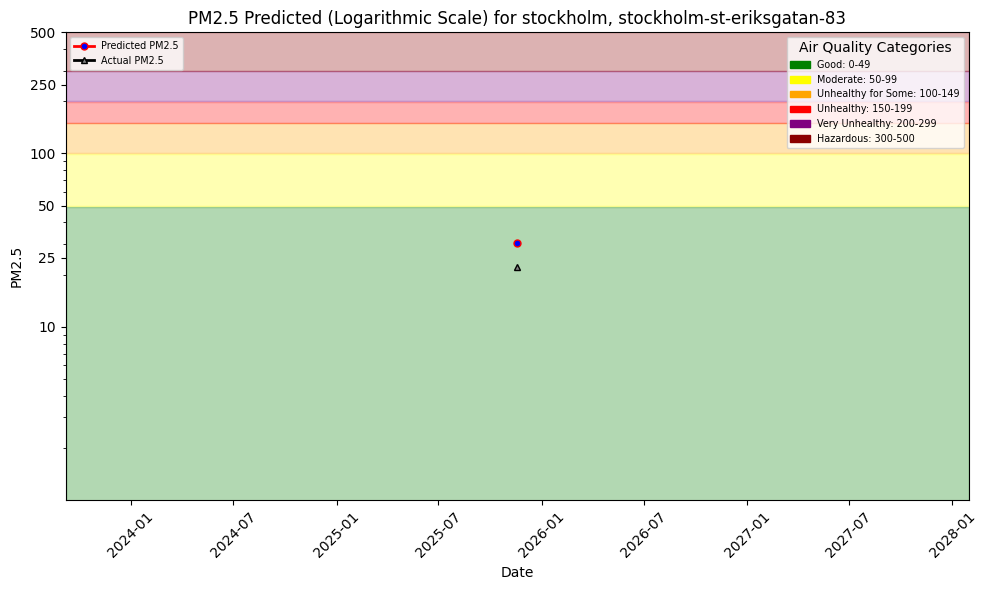

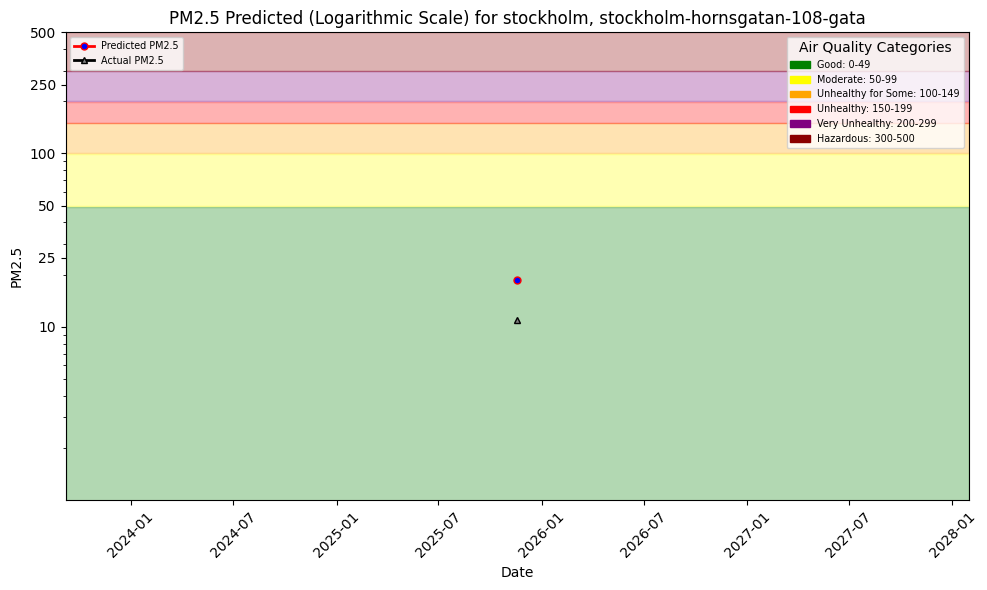

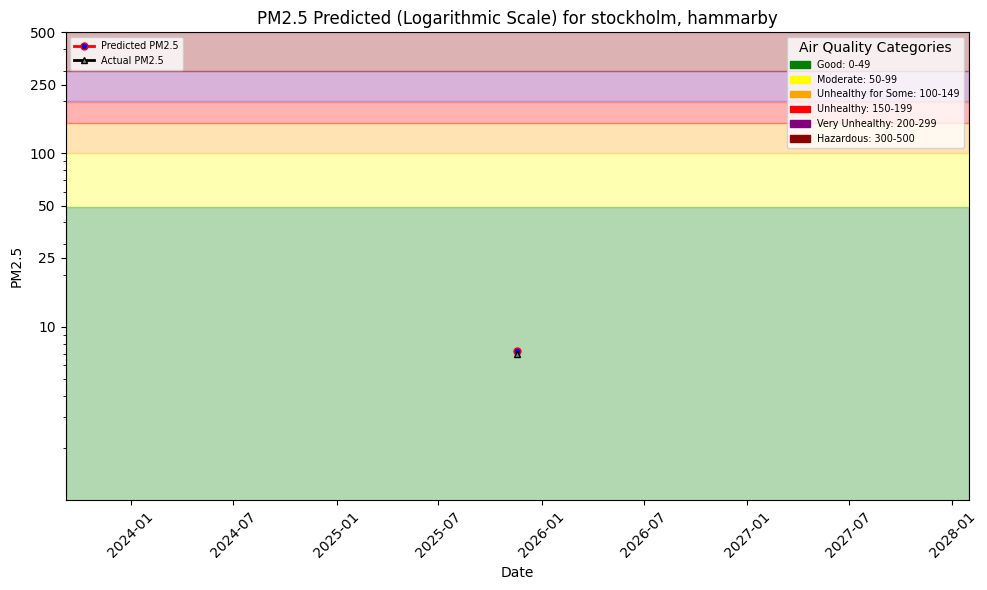

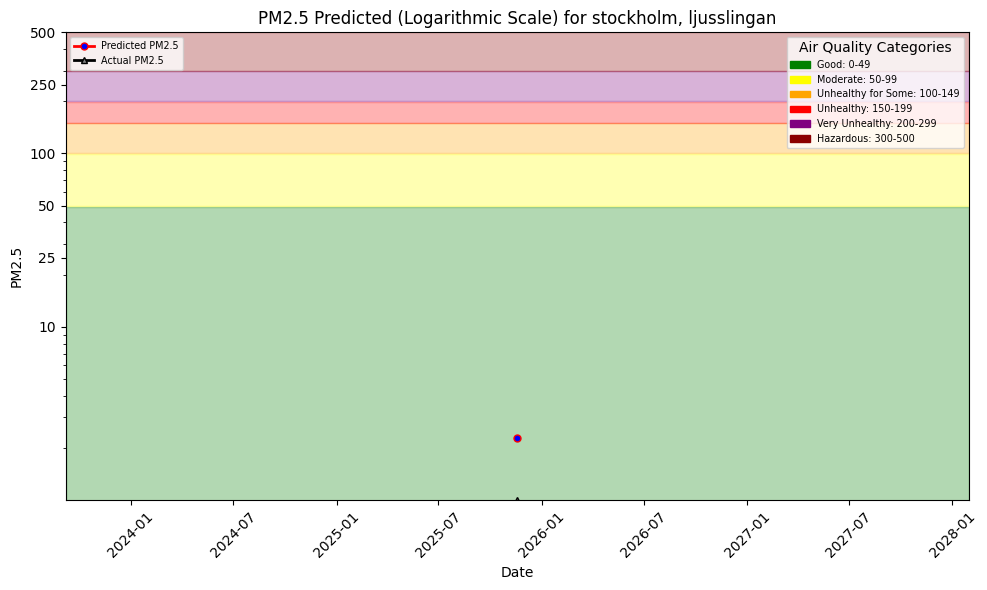

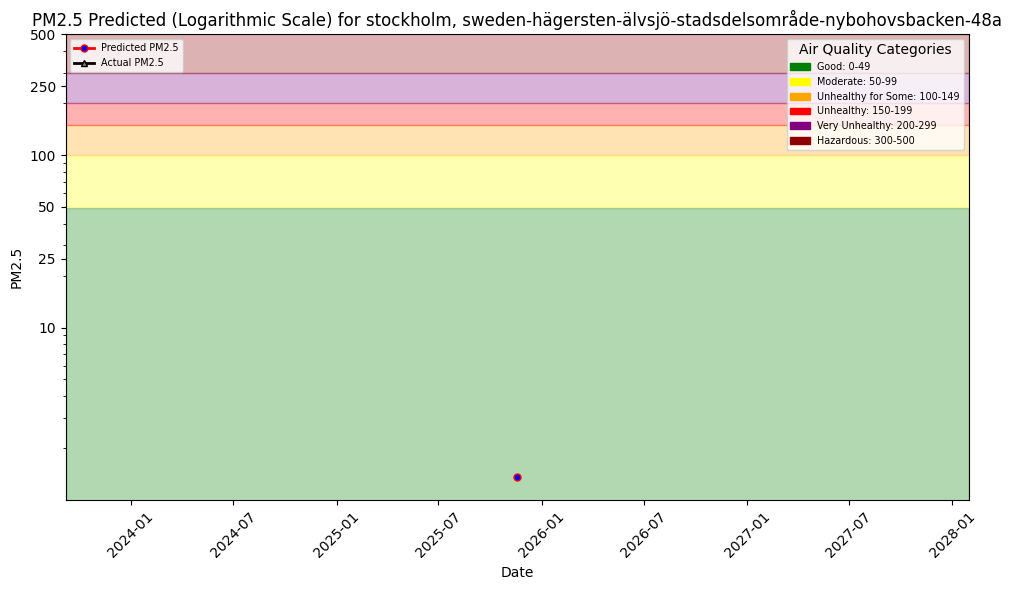

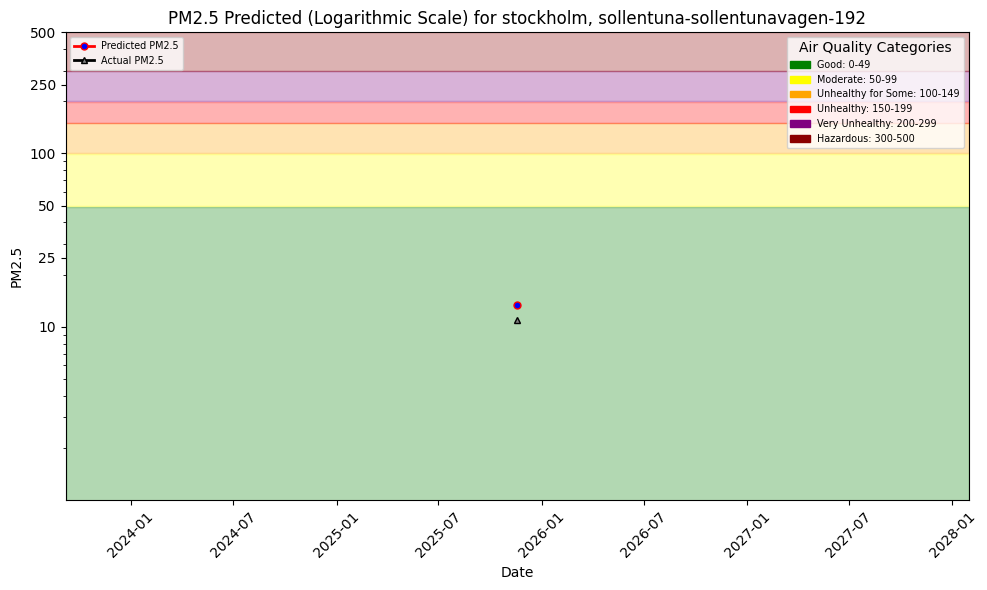

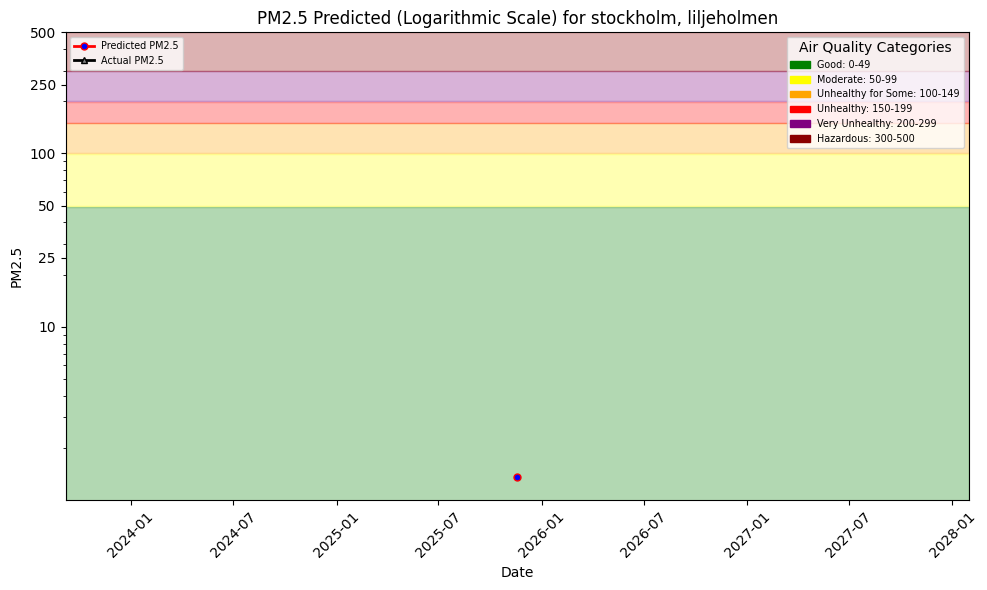

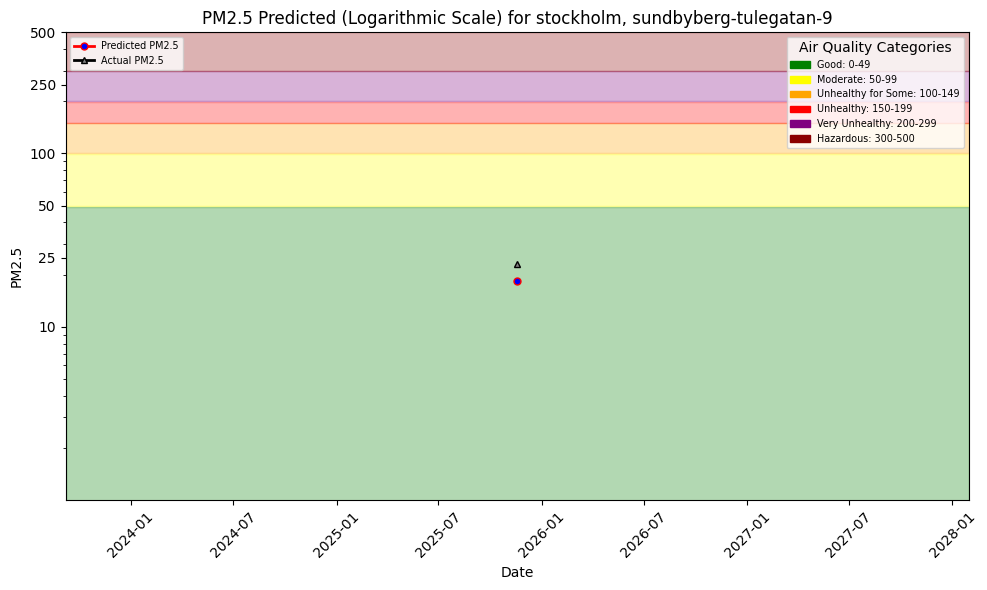

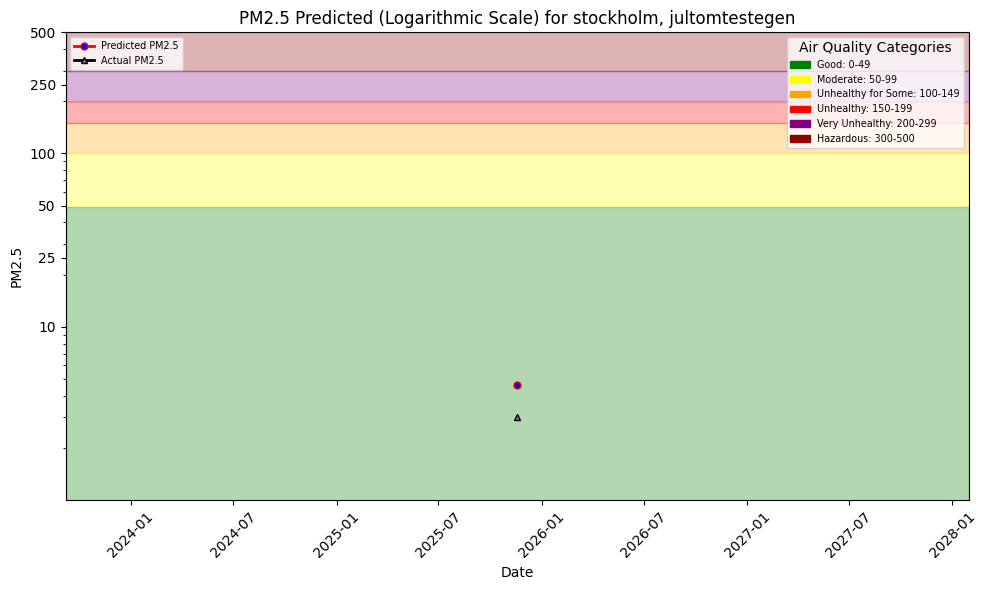

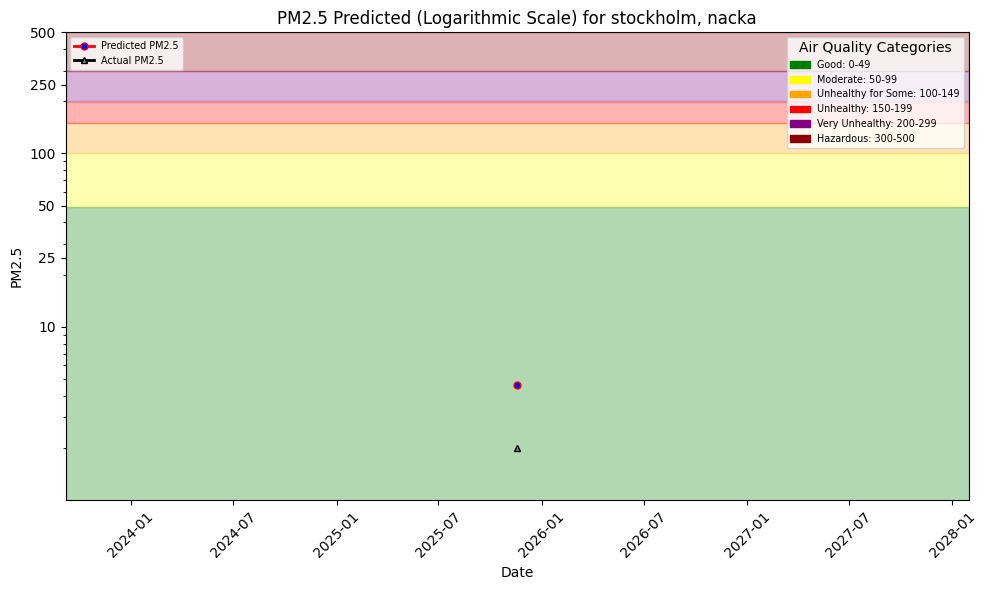

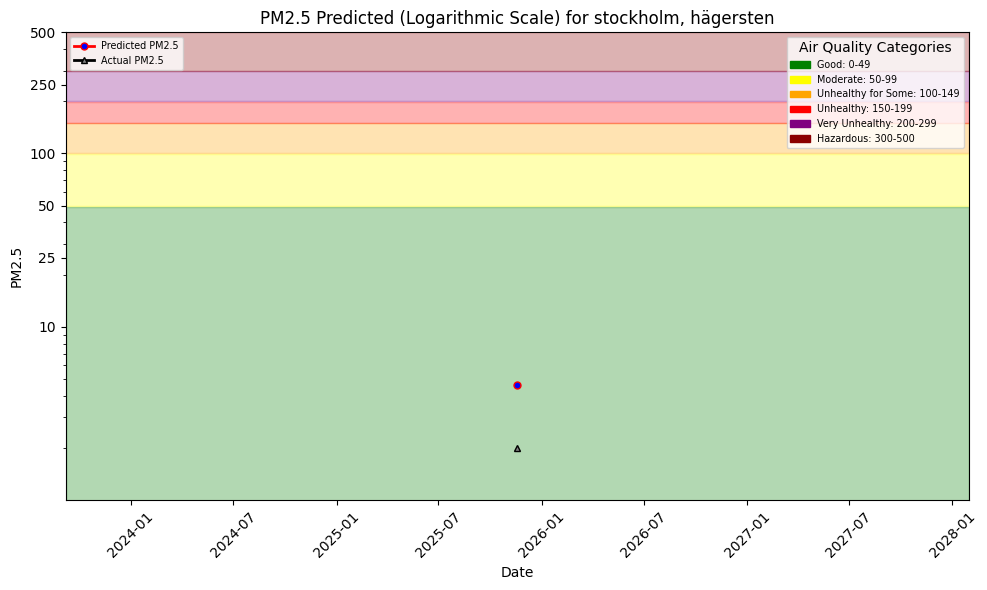

In [30]:
for sensor in config['sensors']:
    outcome_df = air_quality_df[
        (air_quality_df["country"] == sensor['country']) &
        (air_quality_df["city"] == sensor['city']) &
        (air_quality_df["street"] == sensor['street'])
    ][['date', 'pm25']].copy()
    outcome_df["date"] = pd.to_datetime(outcome_df["date"]).dt.tz_localize(None)
    preds_df =  monitoring_df[
        (monitoring_df["country"] == sensor['country']) &
        (monitoring_df["city"] == sensor['city']) &
        (monitoring_df["street"] == sensor['street'])
    ][['date', 'predicted_pm25']].copy()
    preds_df["date"] = pd.to_datetime(preds_df["date"]).dt.tz_localize(None)

    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])

    no_outcomes = (len(hindcast_df) == 0)

    if not no_outcomes:
        street_new = sensor['street'].replace('-', '_')
        street_new = street_new.replace('ä', 'ae')
        street_new = street_new.replace('ö', 'oe')
        street_new = street_new.replace('å', 'oa')
        hindcast_file_path = pred_file_path + f"/pm25_hindcast_{street_new}_{today.strftime('%Y_%m_%d')}.png"
        plt = util.plot_air_quality_forecast(
            sensor['city'], 
            sensor['street'], 
            hindcast_df, 
            hindcast_file_path, 
            hindcast=True)
        plt.show()

### Upload prediction and hindcast to Hopsworks

In [39]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
if dataset_api.exists(f"Resources/airquality/general") == False:
    dataset_api.mkdir(f"Resources/airquality/general")
for sensor in config['sensors']:
    street_new = sensor['street'].replace('-', '_')
    street_new = street_new.replace('ä', 'ae')
    street_new = street_new.replace('ö', 'oe')
    street_new = street_new.replace('å', 'oa')
    dataset_api.upload(pred_file_path + f"/pm25_forecast_{street_new}_{today.strftime('%Y_%m_%d')}.png", "Resources/airquality/general", overwrite=True)
    if not no_outcomes:
        dataset_api.upload(pred_file_path + f"/pm25_hindcast_{street_new}_{today.strftime('%Y_%m_%d')}.png", f"Resources/airquality/general", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/air_quality_models/gener…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/air_quality_models/gener…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/air_quality_models/gener…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/air_quality_models/gener…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/air_quality_models/gener…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/air_quality_models/gener…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/air_quality_models/gener…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/air_quality_models/gener…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/air_quality_models/gener…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/air_quality_models/gener…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/air_quality_models/gener…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279162/settings/fb/path/Resources/airquality


In [42]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y_%m_%d")
for sensor in config['sensors']:
    street_new = sensor['street'].replace('-', '_')
    street_new = street_new.replace('ä', 'ae')
    street_new = street_new.replace('ö', 'oe')
    street_new = street_new.replace('å', 'oa')
    dataset_api.download(
        "Resources/airquality/general" + f"/pm25_forecast_{street_new}_{today.strftime('%Y_%m_%d')}.png", 
        f"{project_root}/backend/air_quality_models/general/downloads", 
        overwrite=True)

Downloading: 0.000%|          | 0/46489 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/47918 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/45307 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/46622 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/53655 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/46125 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/47141 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/47316 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/45163 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/43749 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/44505 elapsed<00:00 remaining<?